In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# se define la ruta para acceder a las imágenes proporcionadas

Mounted at /content/drive


In [ ]:
import torch.nn as nn
from time import sleep
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import glob
import torch
import torchvision
import cv2 as cv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from functools import lru_cache
import random

In [ ]:
# se definen las rutas de acceso a las partes del conjunto de datos
PATH_ = r"/content/drive/MyDrive/sechs/computer_vision/proyecto"
GROUND_TRUTH = PATH_+r'/test/folder'
PATH = PATH_+r'/dataset'

torch.manual_seed(0)

# Modelo

In [ ]:
# se establece la clase que define la arquitectura de la red neuronal como una subclase modulo de pytorch
class CNN(nn.Module):
    def __init__(self):
      # se incializa la clase padre
        super(CNN, self).__init__()
        # se define cada capa como un elemento secuencial, dentro de las cuales se encuentran las capas convolucionales, su función de activación y la normalización de su salida
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.layer_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.layer_5 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.layer_6 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, dilation=2, padding=2, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.layer_7 = nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.layer_8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,out_channels=256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=313, kernel_size=1, stride=1, padding=0, bias=True)
        )
        # se define la funcioón de activación para obtener la distribución de probabilidad de los canales a y b
        self.softmax = nn.Softmax(dim=1)
        # se define la capa convolucional final que dará como resultado la salida del modelo
        self.out = nn.Conv2d(in_channels=313, out_channels=2, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.up = nn.Upsample(scale_factor=4, mode='bilinear')
  # establece el orden que el input sigue dentro de la red
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = nn.Upsample(scale_factor=2, mode='bilinear')(x)
        x = self.layer_5(x)
        x = nn.Upsample(scale_factor=2, mode='bilinear')(x)
        x = self.layer_6(x)
        x = nn.Upsample(scale_factor=2, mode='bilinear')(x)
        x = self.layer_7(x)
        x = nn.Upsample(scale_factor=2, mode='bilinear')(x)
        x = self.layer_8(x)
        logits = self.softmax(x)
        probs = self.out(logits)
        return self.up(probs), probs

# Training

In [ ]:
from numpy.core.fromnumeric import sort
# se define el tamaño de cada  batch como 50 imagenes
batch_size = 50

# para obtener las etiquetas de cada imagen de entrenamiento se define la siguiente funcion
def get_targets():
    # se listan los archivos de las imagenes a color
    filenames = [img for img in glob.glob(f"{GROUND_TRUTH}/*.jpg")]
    filenames = sort(filenames)
    print(filenames)
    # se convierten los mapas de color de las imagenes a Lab para permitir el trataiemto de los mismos en el entrenamiento
    images = [cv.cvtColor(cv.imread(img), cv.COLOR_BGR2LAB) for img in filenames]
    # se cambia la dimnsion de las imagenes para satisfacer las dimensiones de los datso de entrenamiento
    images = [cv.resize(img, (128,128)) for img in images]
    # se establece como un tensor de pytorch
    images = torch.from_numpy(np.asarray([images[i:i+batch_size] for i in range(0, len(images), batch_size)]))
    images = images.float()
    # se realiza un reshape al nesor para que tenga compatibilidad con las dimensiones del conjunto de entrada
    images = torch.reshape(images, (100, 50, 3,128,128))
    images.to('cpu')
    #print(images[0][:,1:].size())
    return images
target = get_targets()

['/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image0000.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image0001.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image0002.jpg'
 ...
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image4997.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image4998.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/test/folder/image4999.jpg']


In [ ]:
# para obtener las etiquetas de cada imagen de entrenamiento se define la siguiente funcion
def get_training_images():
    # se listan los archivos de las imagenes a color
    filenames = [img for img in glob.glob(f"{PATH}/all/*.jpg")]
    filenames = sort(filenames)
    print(filenames)
    # se convierten los mapas de color de las imagenes a Lab para permitir el trataiemto de los mismos en el entrenamiento
    images = [cv.cvtColor(cv.imread(img), cv.COLOR_BGR2GRAY) for img in filenames]
    # se cambia la dimnsion de las imagenes para satisfacer las dimensiones de los datso de entrenamiento
    images = [cv.resize(img, (128,128)) for img in images]
    # se establece como un tensor de pytorch
    images = torch.from_numpy(np.asarray([images[i:i+batch_size] for i in range(0, len(images), batch_size)]))
    images = images.float()
    # se realiza un reshape al nesor para que tenga compatibilidad con las dimensiones del conjunto de entrada
    images = torch.reshape(images, (100, 50,128,128))
    images.to('cpu')
    #print(images[0][:,1:].size())
    return images
training = get_training_images()

['/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0000.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0001.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0002.jpg'
 ...
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image4997.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image4998.jpg'
 '/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image4999.jpg']


In [ ]:
training, target = shuffle(training, target)

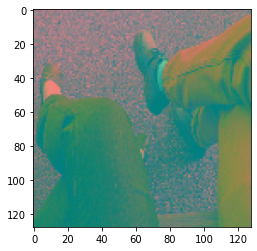

In [ ]:
plt.imshow(torch.reshape(target[0][0], (128,128,3)).int())

torch.Size([100, 50, 128, 128])

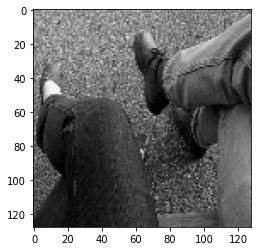

In [ ]:
plt.imshow(torch.reshape(training[0][0], (128,128)).int(), cmap='gray')
training.shape

In [ ]:
# se define la función de entrenamiento recibiendo como parámetros los datos de entrenamiento (dataloader)
# la instancia del modelo, las funciones de perdida, el optimizador, las etiquetas y la cantida de epocas a entrenar
def train_(data, model, loss_a, loss_b, optimizer, target, epochs=3):
    # se define que el modelo entrará a un loop de entrenamiento
    model.train()
    # se itera por la cantida de épocas
    for epoch in range(epochs):
      data, target = shuffle(data, target)
      # se obtiene los datos de cada batch
      for batch, x in enumerate(data):
          # solo se hace uso de la imagen de entrada, ya que pytorch proporciona como etiquetas clases, no imagenes
          x = x[None, :]
          x =  torch.reshape(x, (50,1,128,128))
          x = x.to('cpu')
          # se obtiene la prediccion de la instancia del modelo
          preds, _ = model(x)
          #pred = torch.squeeze(pred, 1)
          # se toman los canales a y b de la imagen a color
          tgt_a, tgt_b = target[batch][:,1], target[batch][:,2]
          pred_a, pred_b = preds[:, 0], preds[:,1]
          # se calculan los errores con las funciones de perdida
          lossA = loss_a(pred_a, tgt_a)
          lossB = loss_b(pred_b, tgt_b)
          # se utiliza el backpropagation para corregir el gradiente
          optimizer.zero_grad()
          (lossA+lossB).backward()
          optimizer.step()
          if ((batch+1)%10==0):
            print(f"batch {batch}  loss: {lossA} {lossB}" )
            #torch.save(model.state_dict(),  f"/content/drive/MyDrive/sechs/computer_vision/proyecto/{17+epoch}_{batch}.pt")
            torch.save(model,  f"/content/drive/MyDrive/sechs/computer_vision/proyecto/saves/{31+epoch}_{batch}.pt")

In [ ]:
#model = CNN().to('cpu')
model = torch.load("/content/drive/MyDrive/sechs/computer_vision/proyecto/saves/30_39.pt") 
from torch import optim
# se definen las funciones de perdida y el optimizador
loss_a = nn.CrossEntropyLoss()
loss_b = nn.CrossEntropyLoss()
# se utiliza el optimizador Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_(training, model, loss_a, loss_b, optimizer, target, 4)

batch 9  loss: 80511.5703125 80871.3984375
batch 19  loss: 81982.2265625 79287.6015625
batch 29  loss: 79426.4375 80705.203125
batch 39  loss: 79579.03125 78113.21875
batch 49  loss: 78819.4296875 79488.8984375
batch 59  loss: 78425.7109375 78569.078125
batch 69  loss: 79184.8984375 79153.3125
batch 79  loss: 81212.296875 79951.609375
batch 89  loss: 79233.15625 78662.4453125
batch 99  loss: 78244.890625 78836.6640625
batch 9  loss: 79232.6171875 78662.0078125
batch 19  loss: 81362.375 78587.0234375
batch 29  loss: 79897.6875 76151.0390625
batch 39  loss: 79631.8671875 80101.7265625
batch 49  loss: 78818.8984375 79488.5
batch 59  loss: 77521.6328125 78038.9921875
batch 69  loss: 78425.7421875 78568.5703125
batch 79  loss: 78562.1328125 79840.5546875


In [ ]:
# se define la función de entrenamiento recibiendo como parámetros los datos de entrenamiento (dataloader)
# la instancia del modelo, las funciones de perdida, el optimizador, las etiquetas y la cantida de epocas a entrenar
def train(dataloader, model, loss_a, loss_b, optimizer, target, epochs=3):
    size = len(dataloader.dataset)
    print(len(target))
    # se define que el modelo entrará a un loop de entrenamiento
    model.train()
    # se itera por la cantida de épocas
    for epoch in range(epochs):
      # se obtiene los datos de cada batch
      for batch, (x,y) in enumerate(dataloader):
          # solo se hace uso de la imagen de entrada, ya que pytorch proporciona como etiquetas clases, no imagenes
          x = x.to('cpu')
          print(x.shape)
          # se obtiene la prediccion de la instancia del modelo
          preds, _ = model(x)
          break
          #pred = torch.squeeze(pred, 1)
          # se toman los canales a y b de la imagen a color
          tgt_a, tgt_b = target[batch][:,1], target[batch][:,2]
          pred_a, pred_b = preds[:, 0], preds[:,1]
          # se calculan los errores con las funciones de perdida
          lossA = loss_a(pred_a, tgt_a)
          lossB = loss_b(pred_b, tgt_b)
          # se utiliza el backpropagation para corregir el gradiente
          optimizer.zero_grad()
          (lossA+lossB).backward()
          optimizer.step()
          if ((batch+1)%10==0):
            print(f"batch {batch}  loss: {lossA} {lossB}" )
            torch.save(model.state_dict(),  f"/content/drive/MyDrive/sechs/computer_vision/proyecto/{13+epoch}_{batch}.pt")
            torch.save(model,  f"/content/drive/MyDrive/sechs/computer_vision/proyecto/saves/{epoch}_{batch}.pt")
      break

In [ ]:
# se instancia el modelo cargandolo al CPU
model = CNN().to('cpu')
model.load_state_dict(torch.load("/content/drive/MyDrive/sechs/computer_vision/proyecto/13_9.pt"))

<All keys matched successfully>

In [ ]:
from torch import optim
# se definen las funciones de perdida y el optimizador
loss_a = nn.CrossEntropyLoss()
loss_b = nn.CrossEntropyLoss()
# se utiliza el optimizador Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# se utiliza un transformadore de los datos de ehtrada, definiendo que se desea su representacion a un solo canal, como tensores y con dimension de 128x128 pixeles
tr = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(), transforms.Resize(128)])
# se toman los datos del folder que contiene el conjunto de datos
training_data = torchvision.datasets.ImageFolder(PATH, tr)
# se instancia un objeto dataloader
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)
train_dataloader

In [ ]:
train(train_dataloader, model, loss_a, loss_b, optimizer, target, 3)

100
torch.Size([50, 1, 128, 128])


In [ ]:
#train(train_dataloader, model, loss_a, loss_b, optimizer, target)
target = get_targets()

In [ ]:
# se utiliza un transformadore de los datos de ehtrada, definiendo que se desea su representacion a un solo canal, como tensores y con dimension de 128x128 pixeles
tr = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(), transforms.Resize(128)])
# se toman los datos del folder que contiene el conjunto de datos
training_data = torchvision.datasets.ImageFolder(PATH, tr)

In [ ]:
target.shape
target_ = target.reshape((5000, 3,128,128))
training_data.targets = target_
print((training_data.imgs), training_data.targets.shape )
train_dataloader_ = DataLoader(training_data, batch_size=batch_size, shuffle=True)
train_dataloader_

[('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0000.jpg', 0), ('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0001.jpg', 0), ('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0002.jpg', 0), ('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0003.jpg', 0), ('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0004.jpg', 0), ('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0005.jpg', 0), ('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0006.jpg', 0), ('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0007.jpg', 0), ('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0008.jpg', 0), ('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0009.jpg', 0), ('/content/drive/MyDrive/sechs/computer_vision/proyecto/dataset/all/image0010.jpg', 0), ('/content/drive/MyDrive/sechs/

In [ ]:
target_.shape
e = torch.randperm(target_.shape[0])
t = target_[e].view(target_.size())

In [ ]:
training.shape

torch.Size([100, 50, 128, 128])